# Perovskite-Si tandem cell with pyramidal surfaces

This example shows how you can simulate a perovskite-Si tandem cell with pyramidal
surface textures, where the perovskite and other surface layers are assumed to be
deposited conformally (i.e., also in a pyramid shape) on top of the Si. The
perovskite optical constants are from
[this paper](https://pubs.acs.org/doi/pdf/10.1021/acsenergylett.8b00089), while the structure is based on
[this paper](https://doi.org/10.1038/s41563-018-0115-4) We will
calculate
total reflection, transmission and absorption per layer as well as the
wavelength-dependent absorption profiles in the perovskite and Si, which can be used
in e.g. device simulations. We will look at the effect of treating the layers
deposited on Si (including the perovskite) coherently or incoherently.

First, import relevant packages and RayFlare functions:

In [1]:
import numpy as np
import os

from solcore.structure import Layer
from solcore.constants import q
from solcore import material
from solcore.absorption_calculator import search_db, download_db
from solcore.light_source import LightSource

from rayflare.textures import regular_pyramids
from rayflare.options import default_options
from rayflare.ray_tracing import rt_structure
import matplotlib.pyplot as plt
import seaborn as sns

from cycler import cycler

Now we set some relevant options. We will scan across 20 x 20 surface points of the
pyramid unit cell between 300 and 1200 nm, for unpolarized, normally-incident light.
The `randomize_surface` option is set to True to prevent [correlation between the
incident position on the front and rear pyramids](https://aip.scitation
.org/doi/pdf/10.1063/1.339189). The `n_jobs` option is set to -1, which means that
all available cores will be used. If you want to use all but one core, change this to
 -2 etc. We also need to provide a `project_name` to save the lookup tables which will be calculated using TMM to use during ray-tracing.

In [2]:
wavelengths = np.linspace(300, 1200, 40) * 1e-9

AM15G = LightSource(source_type="standard", version="AM1.5g", x=wavelengths,
                    output_units="photon_flux_per_m")

options = default_options()
options.wavelength = wavelengths
options.nx = 20
options.ny = options.nx
options.n_rays = 4 * options.nx**2
options.depth_spacing = 1e-9
options.pol = "u"
options.I_thresh = 1e-3
options.project_name = "perovskite_Si_rt"
options.randomize_surface = True
options.n_jobs = -1 # use all cores; to use all but one, change to -2 etc.

## Adding custom materials

We define our materials. Note that some of these are custom materials added to the database; we only need to do this once. We then define the front layer stack (i.e. all the materials which are on top of the Si, excluding Si itself, which will be the 'bulk' material) and the rear layer stack. Layer stacks are always defined starting with the layer closest to the top of the cell.

In [3]:
# Can comment out this block after running once to add materials to the database
from solcore.material_system import create_new_material

create_new_material("Perovskite_CsBr_1p6eV", "data/CsBr10p_1to2_n_shifted.txt",
                    "data/CsBr10p_1to2_k_shifted.txt")
create_new_material("ITO_lowdoping", "data/model_back_ito_n.txt",
                    "data/model_back_ito_k.txt")
create_new_material("aSi_i", "data/model_i_a_silicon_n.txt",
                    "data/model_i_a_silicon_k.txt")
create_new_material("aSi_p", "data/model_p_a_silicon_n.txt",
                    "data/model_p_a_silicon_k.txt")
create_new_material("aSi_n", "data/model_n_a_silicon_n.txt",
                    "data/model_n_a_silicon_k.txt")
create_new_material("C60", "data/C60_Ren_n.txt",
                    "data/C60_Ren_k.txt")
create_new_material("IZO", "data/IZO_Ballif_rO2_10pcnt_n.txt",
                    "data/IZO_Ballif_rO2_10pcnt_k.txt")
# Comment out until here

In [4]:
# download_db()

In [5]:
MgF2_pageid = search_db(os.path.join("MgF2", "Rodriguez-de Marcos"))[0][0];
Ag_pageid = search_db(os.path.join("Ag", "Jiang"))[0][0];

Si = material("Si")()
Air = material("Air")()
MgF2 = material(str(MgF2_pageid), nk_db=True)()
ITO_back = material("ITO_lowdoping")()
Perovskite = material("Perovskite_CsBr_1p6eV")()
Ag = material(str(Ag_pageid), nk_db=True)()
aSi_i = material("aSi_i")()
aSi_p = material("aSi_p")()
aSi_n = material("aSi_n")()
LiF = material("LiF")()
IZO = material("IZO")()
C60 = material("C60")()

# stack based on doi:10.1038/s41563-018-0115-4
front_materials = [
    Layer(100e-9, MgF2),
    Layer(110e-9, IZO),
    Layer(15e-9, C60),
    Layer(1e-9, LiF),
    Layer(440e-9, Perovskite),
    Layer(6.5e-9, aSi_n),
    Layer(6.5e-9, aSi_i),
]

back_materials = [Layer(6.5e-9, aSi_i), Layer(6.5e-9, aSi_p), Layer(240e-9, ITO_back)]

Database file found at /Users/z3533914/.solcore/nk/nk.db
1 results found.
pageid	shelf	book	page	filepath	hasrefractive	hasextinction	rangeMin	rangeMax	points
234	main	MgF2	Rodriguez-de_Marcos	main/MgF2/Rodriguez-de Marcos.yml	1	1	0.0299919	2.00146	960
Database file found at /Users/z3533914/.solcore/nk/nk.db
1 results found.
pageid	shelf	book	page	filepath	hasrefractive	hasextinction	rangeMin	rangeMax	points
2	main	Ag	Jiang	main/Ag/Jiang.yml	1	1	0.3	2.0	1701


## Defining the interfaces and structure

Now we define our front and back surfaces, including `interface_layers`. We will use
regular pyramids for both the front and back surface; these pyramids point out on both sides, but since the direction of the pyramids is defined relative to the front surface, we must set `upright=True` for the top surface and `upright=False` for the rear surface. We also gives the surfaces a name (used to save the lookup table data) and ask RayFlare to calculate the absorption profile in the 5th layer, which is the perovskite.

In [6]:
triangle_surf = regular_pyramids(
    elevation_angle=55,
    upright=True,
    size=1,
    interface_layers=front_materials,
    name="coh_front",
    prof_layers=[5],
)

triangle_surf_back = regular_pyramids(
    elevation_angle=55,
    upright=False,
    size=1,
    interface_layers=back_materials,
    name="Si_back",
    coherency_list=["i"] * len(back_materials),
)

Now we make our ray-tracing structure by combining the front and back surfaces,
specifying the material in between (Si) and setting its width to 260 microns. In
order to use the TMM lookuptables to calculate reflection/transmission/absorption
probabilities we must also set `use_TMM=True`.

In [7]:
%%capture

rtstr_coh = rt_structure(
    textures=[triangle_surf, triangle_surf_back],
    materials=[Si],
    widths=[260e-6],
    incidence=Air,
    transmission=Ag,
    use_TMM=True,
    options=options,
    overwrite=True,
    save_location="current",
)

# calculate:
result_coh = rtstr_coh.calculate(options)

INFO: Pre-computing TMM lookup table(s)


Database file found at /Users/z3533914/.solcore/nk/nk.db
Material main/MgF2/Rodriguez-de Marcos.yml loaded.
Database file found at /Users/z3533914/.solcore/nk/nk.db
Material main/MgF2/Rodriguez-de Marcos.yml loaded.
Database file found at /Users/z3533914/.solcore/nk/nk.db
Material main/Ag/Jiang.yml loaded.
Database file found at /Users/z3533914/.solcore/nk/nk.db
Material main/Ag/Jiang.yml loaded.



INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
I

## Incoherent calculation

Now we define the same front surface and structure again, except now we will treat
all the layers incoherently (i.e. no thin-film interference) in the TMM.

In [8]:
%%capture

triangle_surf = regular_pyramids(
    elevation_angle=55,
    upright=True,
    size=1,
    interface_layers=front_materials,
    coherency_list=["i"] * len(front_materials),
    name="inc_front",
    prof_layers=[5],
)

rtstr_inc = rt_structure(
    textures=[triangle_surf, triangle_surf_back],
    materials=[Si],
    widths=[260e-6],
    incidence=Air,
    transmission=Ag,
    use_TMM=True,
    options=options,
    overwrite=True,
    save_location="current",
)

result_inc = rtstr_inc.calculate(options)

INFO: Pre-computing TMM lookup table(s)
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength...
INFO: Calculating next wavelength..

Now we plot the results for reflection, transmission, and absorption per layer for both the coherent and incoherent cases.

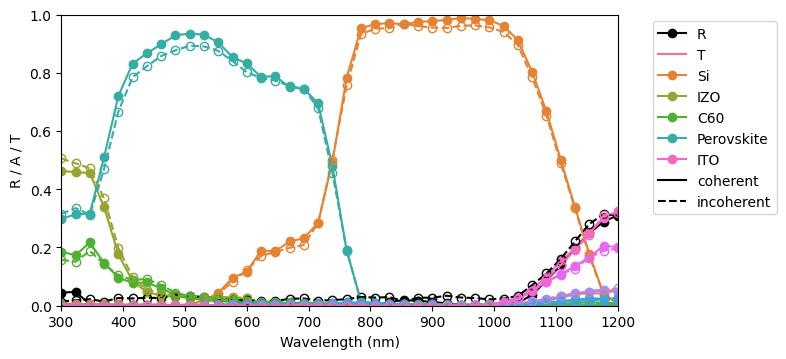

In [9]:
pal = sns.color_palette("husl", n_colors=len(front_materials) + len(back_materials) + 2)
# create a colour palette

cols = cycler("color", pal)
# set this as the default colour palette in matplotlib

params = {
    "axes.prop_cycle": cols,
}

plt.rcParams.update(params)

fig = plt.figure(figsize=(8, 3.7))
plt.subplot(1, 1, 1)
plt.plot(wavelengths * 1e9, result_coh["R"], "-ko", label="R")
plt.plot(wavelengths * 1e9, result_coh["T"], mfc="none", label="T")
plt.plot(wavelengths * 1e9, result_coh["A_per_layer"][:, 0], "-o", label='Si')
plt.plot(wavelengths * 1e9, result_coh["A_per_interface"][0], "-o",
         label=[None, "IZO", "C60", None, "Perovskite", None, None])
plt.plot(wavelengths * 1e9, result_coh["A_per_interface"][1], "-o",
         label=[None, None, "ITO"])

plt.plot(wavelengths * 1e9, result_inc["R"], "--ko", mfc="none")
plt.plot(wavelengths * 1e9, result_inc["T"], mfc="none")
plt.plot(wavelengths * 1e9, result_inc["A_per_layer"][:, 0], "--o", mfc="none")
plt.plot(wavelengths * 1e9, result_inc["A_per_interface"][0], "--o", mfc="none")
plt.plot(wavelengths * 1e9, result_inc["A_per_interface"][1], "--o", mfc="none")

plt.plot([300, 301], [0, 0], "-k", label="coherent")
plt.plot([300, 301], [0, 0], "--k", label="incoherent")
plt.xlabel("Wavelength (nm)")
plt.ylabel("R / A / T")
plt.ylim(0, 1)
plt.xlim(300, 1200)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

Calculate and print the limiting short-circuit current per junction:

In [10]:
Jmax_Pero_coh = q*np.trapz(result_coh["A_per_interface"][0][:,4]*AM15G.spectrum()[1],
                                                        x=wavelengths)/10
Jmax_Si_coh = q*np.trapz(result_coh["A_per_layer"][:, 0]*AM15G.spectrum()[1],
                     x=wavelengths)/10

print("Limiting short-circuit currents in coherent calculation (mA/cm2): {:.2f} / {:"
      ".2f}".format(Jmax_Pero_coh, Jmax_Si_coh))

Jmax_Pero_inc = q*np.trapz(result_inc["A_per_interface"][0][:,4]*AM15G.spectrum()[1],
                                                        x=wavelengths)/10
Jmax_Si_inc = q*np.trapz(result_inc["A_per_layer"][:, 0]*AM15G.spectrum()[1],
                     x=wavelengths)/10

print("Limiting short-circuit currents in coherent calculation (mA/cm2): {:.2f} / {:"
      ".2f}".format(Jmax_Pero_inc, Jmax_Si_inc))

Limiting short-circuit currents in coherent calculation (mA/cm2): 19.27 / 21.47
Limiting short-circuit currents in coherent calculation (mA/cm2): 18.67 / 20.98


## Absorption profiles

We can also plot the absorption profiles, for wavelengths up to 800 nm, in the
perovskite (since we asked the solver to calculate the profile in the perovskite
layer above).

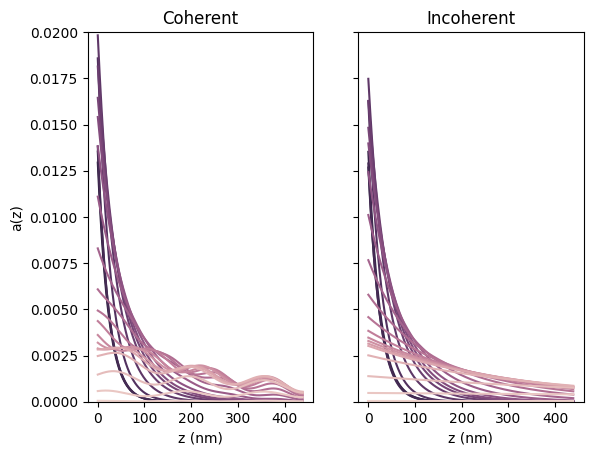

In [11]:
wl_Eg = wavelengths < 800e-9

pal = sns.cubehelix_palette(sum(wl_Eg), reverse=True)
cols = cycler("color", pal)
params = {
    "axes.prop_cycle": cols,
}
plt.rcParams.update(params)

pos = np.arange(0, rtstr_coh.interface_layer_widths[0][4], options.depth_spacing*1e9)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(pos, result_coh["interface_profiles"][0][wl_Eg].T)
ax1.set_ylim(0, 0.02)
ax1.set_xlabel("z (nm)")
ax1.set_ylabel("a(z)")
ax1.set_title("Coherent")
ax2.plot(pos, result_inc["interface_profiles"][0][wl_Eg].T)
ax2.set_ylim(0, 0.02)
ax2.yaxis.set_ticklabels([])
ax2.set_xlabel("z (nm)")
ax2.set_title("Incoherent")
plt.show()

We see that, as expected, the coherent case shows interference fringes while the incoherent case does not. We can also plot the absorption profile in the Si (> 800 nm):

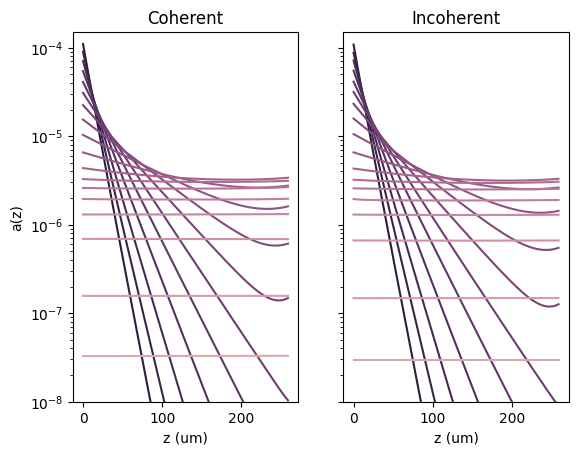

In [12]:
pos_bulk = pos = np.arange(0, rtstr_coh.widths[0]*1e6, options.depth_spacing_bulk*1e6)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.semilogy(pos, result_coh["profile"][~wl_Eg].T)
ax1.set_ylim(1e-8, 0.00015)
ax1.set_xlabel("z (um)")
ax1.set_ylabel("a(z)")
ax1.set_title("Coherent")
ax2.semilogy(pos, result_inc["profile"][~wl_Eg].T)
ax2.set_ylim(1e-8, 0.00015)
ax2.yaxis.set_ticklabels([])
ax2.set_xlabel("z (um)")
ax2.set_title("Incoherent")
plt.show()

## Questions

- Why do you think the total absorption is slightly lower in the incoherent calculation?
- Even though the layers on top of the Si are not very thick compared to the
  wavelength, and they are the first thing encountered by the light, why might it make
  sense to treat them incoherently?
- Can you improve the current-matching (at least in terms of limiting currents)
  between the perovskite and the Si?